In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from matplotlib.font_manager import FontProperties
from scipy import integrate
from scipy import special
from scipy import signal, interpolate
from numba import jit
import constnumberfile as cn
import functionfileisothermalUCMH as ff
#import sys; sys.path.append('..')
#import CAMBPS.PSfun as PS
#import subprocess
#subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'UCMH.ipynb'])

In [2]:
zmin=10
#zlist=np.arange(zmin,40+1,2)      
zlist=np.array([20,25,30])
zclist=np.array([30+1e-5,50,100,200,500,800,1000,4000])
kmin=ff.kvir(zmin,1e4)
#kmin=1e2
kmax=1e7
dk=100
klist=np.logspace(np.log10(kmin),np.log10(kmax),dk)
dxy=50
J=5
k01=np.logspace(-J,0,dxy)
k02=np.logspace(0,-J,dxy)
k05=np.hstack((-k02,[0],k01))
k06=np.hstack(([0],k01))

In [3]:
@jit ('f8(f8[:],f8[:],f8[:],f8[:],f8[:])')
def Tbave(klist,zclist,zlist,k05,k06):
    C=np.zeros((len(klist),len(zclist),len(zlist)))
    Rs=np.zeros((len(klist),len(zclist),len(zlist)))
    Rv=np.zeros((len(klist),len(zclist),len(zlist)))
    Mv=np.zeros((len(klist),len(zclist),len(zlist)))
    Tg0=np.zeros((len(klist),len(zclist),len(zlist)))
    Rg0=np.zeros((len(klist),len(zclist),len(zlist)))
    TGasave=np.zeros((len(klist),len(zclist),len(zlist)))
    RGasave=np.zeros((len(klist),len(zclist),len(zlist)))
    TBav=np.zeros((len(klist),len(zclist),len(zlist)))
    Tauav=np.zeros((len(klist),len(zclist),len(zlist)))
    TS=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    Xc=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    TBr=np.zeros((len(klist),len(zclist),len(zlist),len(k05)))
    taucum=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    rgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    tgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    for i,kk in enumerate(klist):
        for j,zc in enumerate(zclist):
            for k,z in enumerate(zlist):
                c,rs,rv,mv=ff.ksUCMHprofiledata(z,zc,kk)
                if (mv>ff.MJ(z)):
                    tg00,rg00,etaM=ff.trg0(z,zc,c,rv,mv,30)
                else:
                    etaM=ff.trg0(z,zc,c,rv,mv,30)[2]
                    tg00,rg00=ff.bondic(kk,z,zc,etaM)
                Tgasigm,Rgasigm=ff.TRgasigm(z)
                Tgas0,Rgas0=ff.TRgas(k06,c,tg00,rg00,etaM)
                Tgas=Tgas0+Tgasigm
                Rgas=Rgas0+Rgasigm
                Tgasave,Rgasave=ff.TRgasave(Tgas,Rgas,k06)
                ts,xc=ff.Ts(k05,k05,z,c,kk,0,tg00,rg00,etaM)
                Tbr,tau=ff.Tbr(k05,k05,z,kk,c,tg00,rg00,ts,rv,etaM)
                Tbav=ff.TbaveM(Tbr,k06)
                tauav=ff.TbaveM(tau[:,len(k05)-1],k06)
                C[i,j,k]=c
                Rs[i,j,k]=rs
                Rv[i,j,k]=rv
                Mv[i,j,k]=mv
                Tg0[i,j,k]=tg00+Tgasigm
                rgas[i,j,k]=Rgas
                tgas[i,j,k]=Tgas
                Rg0[i,j,k]=rg00+Rgasigm
                TGasave[i,j,k]=Tgasave
                RGasave[i,j,k]=Rgasave
                TS[i,j,k]=ts
                Xc[i,j,k]=xc
                TBav[i,j,k]=Tbav
                Tauav[i,j,k]=tauav
                TBr[i,j,k]=Tbr
                taucum[i,j,k]=tau
        if(i%10==0):
            print(i)
    return C,Rs,Rv,Mv,Tg0,rgas,tgas,Rg0,TGasave,RGasave,TBav,Tauav,TS,Xc,TBr,taucum

In [4]:
@jit ('f8(f8[:],f8[:],f8[:],f8[:],f8[:])')
def Tbavenb(klist,zclist,zlist,k05,k06):
    C=np.zeros((len(klist),len(zclist),len(zlist)))
    Rs=np.zeros((len(klist),len(zclist),len(zlist)))
    Rv=np.zeros((len(klist),len(zclist),len(zlist)))
    Mv=np.zeros((len(klist),len(zclist),len(zlist)))
    Tg0=np.zeros((len(klist),len(zclist),len(zlist)))
    Rg0=np.zeros((len(klist),len(zclist),len(zlist)))
    TGasave=np.zeros((len(klist),len(zclist),len(zlist)))
    RGasave=np.zeros((len(klist),len(zclist),len(zlist)))
    TBav=np.zeros((len(klist),len(zclist),len(zlist)))
    Tauav=np.zeros((len(klist),len(zclist),len(zlist)))
    TS=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    Xc=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    TBr=np.zeros((len(klist),len(zclist),len(zlist),len(k05)))
    taucum=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    rgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    tgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    for i,kk in enumerate(klist):
        for j,zc in enumerate(zclist):
            for k,z in enumerate(zlist):
                c,rs,rv,mv=ff.ksUCMHprofiledata(z,zc,kk)
                tg00,rg00,etaM=ff.trg0(z,zc,c,rv,mv,30)
                Tgasigm,Rgasigm=ff.TRgasigm(z)
                Tgas0,Rgas0=ff.TRgas(k06,c,tg00,rg00,etaM)
                Tgas=Tgas0+Tgasigm
                Rgas=Rgas0+Rgasigm
                Tgasave,Rgasave=ff.TRgasave(Tgas,Rgas,k06)
                ts,xc=ff.Ts(k05,k05,z,c,kk,0,tg00,rg00,etaM)
                Tbr,tau=ff.Tbr(k05,k05,z,kk,c,tg00,rg00,ts,rv,etaM)
                Tbav=ff.TbaveM(Tbr,k06)
                tauav=ff.TbaveM(tau[:,len(k05)-1],k06)
                C[i,j,k]=c
                Rs[i,j,k]=rs
                Rv[i,j,k]=rv
                Mv[i,j,k]=mv
                Tg0[i,j,k]=tg00+Tgasigm
                rgas[i,j,k]=Rgas
                tgas[i,j,k]=Tgas
                Rg0[i,j,k]=rg00+Rgasigm
                TGasave[i,j,k]=Tgasave
                RGasave[i,j,k]=Rgasave
                TS[i,j,k]=ts
                Xc[i,j,k]=xc
                TBav[i,j,k]=Tbav
                Tauav[i,j,k]=tauav
                TBr[i,j,k]=Tbr
                taucum[i,j,k]=tau
        if(i%10==0):
            print(i)
    return C,Rs,Rv,Mv,Tg0,rgas,tgas,Rg0,TGasave,RGasave,TBav,Tauav,TS,Xc,TBr,taucum

In [5]:
C,Rs,Rv,Mv,Tg0,rgas,tgas,Rg0,TGasave,RGasave,TBav,Tauav,TS,Xc,TBr,taucum=Tbave(klist,zclist,zlist,k05,k06)

0
10
20
30
40
50
60
70
80
90


In [6]:
Cnb,Rsnb,Rvnb,Mvnb,Tg0nb,rgasnb,tgasnb,Rg0nb,TGasavenb,RGasavenb,TBavnb,Tauavnb,TSnb,Xcnb,TBrnb,taucumnb=Tbavenb(klist,zclist,zlist,k05,k06)

0
10
20
30
40
50
60
70
80
90


<font size=10> Mass evolution </font>

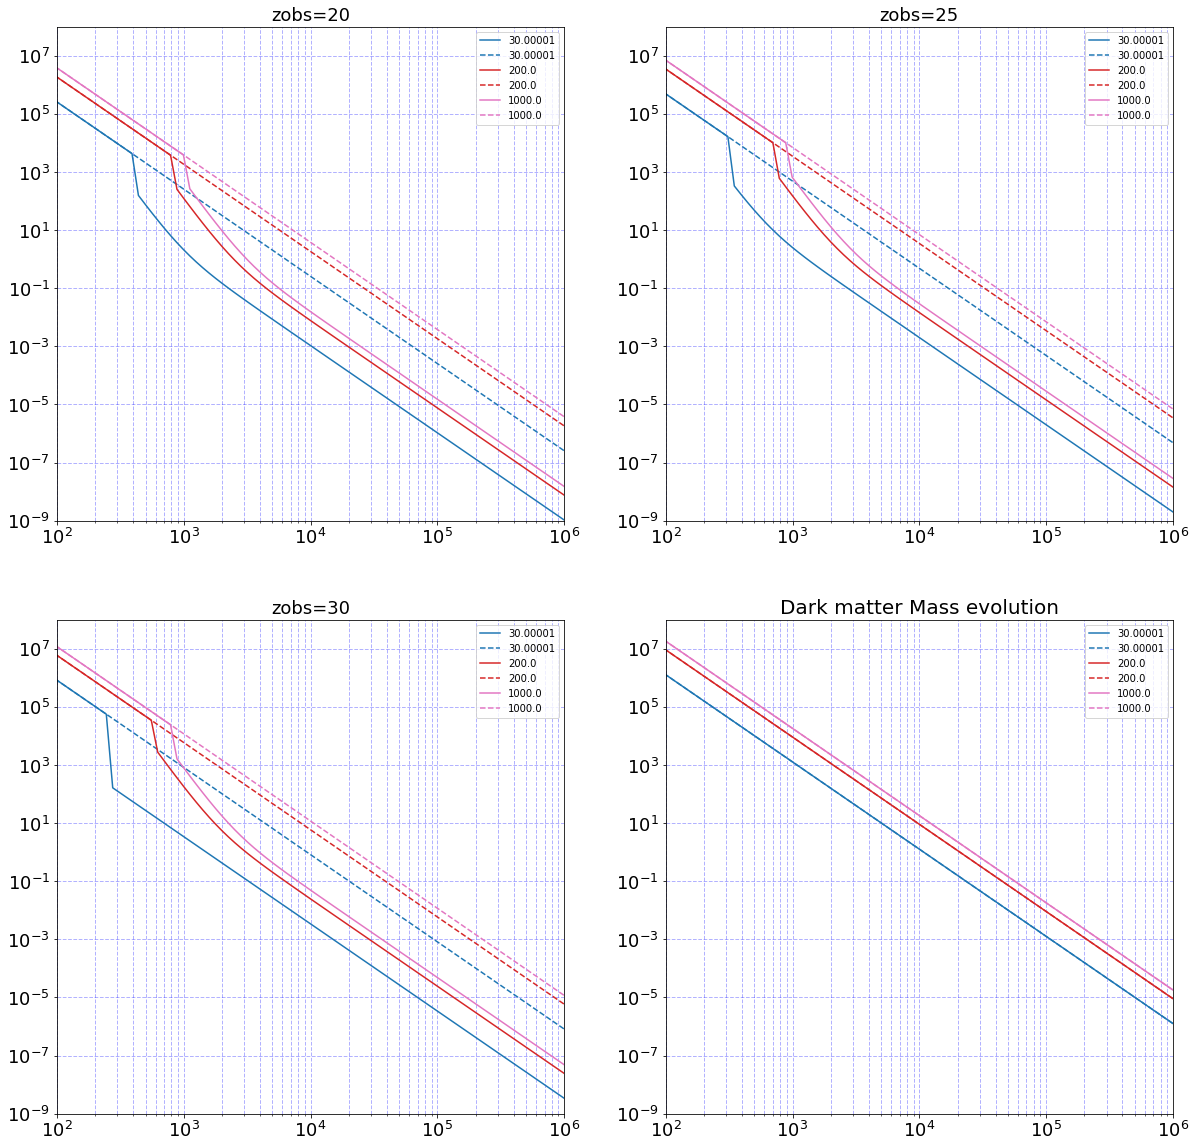

In [7]:
fig, ax = plt.subplots(2, 2,figsize=(20, 20))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0,7,3):
    ax[0,0].loglog(klist,(4*np.pi/3)*Rv[:,i,0]**3*RGasave[:,i,0]*cn.kgm_MMpc,label=zclist[i],color=cycle[i])
    ax[0,0].loglog(klist,(4*np.pi/3)*Rv[:,i,0]**3*RGasavenb[:,i,0]*cn.kgm_MMpc,label=zclist[i],linestyle='--',color=cycle[i])
ax[0,0].set_title(label='zobs=20',size=18)
ax[0,0].axhline(y=ff.rhob(zlist[0]))
for i in range(0,7,3):
    ax[0,1].loglog(klist,(4*np.pi/3)*Rv[:,i,0]**3*RGasave[:,i,1]*cn.kgm_MMpc,label=zclist[i],color=cycle[i])
    ax[0,1].loglog(klist,(4*np.pi/3)*Rv[:,i,0]**3*RGasavenb[:,i,1]*cn.kgm_MMpc,label=zclist[i],linestyle='--',color=cycle[i])
ax[0,1].set_title(label='zobs=25',size=18)
ax[0,1].axhline(y=ff.rhob(zlist[1]))
for i in range(0,7,3):
    ax[1,0].loglog(klist,(4*np.pi/3)*Rv[:,i,0]**3*RGasave[:,i,2]*cn.kgm_MMpc,label=zclist[i],color=cycle[i])
    ax[1,0].loglog(klist,(4*np.pi/3)*Rv[:,i,0]**3*RGasavenb[:,i,2]*cn.kgm_MMpc,label=zclist[i],linestyle='--',color=cycle[i])
ax[1,0].set_title(label='zobs=30',size=18)
for i in range(0,7,3):
    ax[1,1].loglog(klist,Mv[:,i,0],label=zclist[i],color=cycle[i])
    ax[1,1].loglog(klist,Mvnb[:,i,0],label=zclist[i],linestyle='--',color=cycle[i])
ax[1,1].set_title(label='Dark matter Mass evolution',size=20)

for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "both", axis = "both", color = "blue", alpha = 0.3,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        ax[i,j].set_xlim(1e2,1e6)
        ax[i,j].set_ylim(1e-9,1e8)
        ax[i,j].tick_params(labelsize=18)

<font size=10> brightness temperture $\delta T_{b}(z,zc)$ </font>

Text(0.5, 1.0, 'zc=1000')

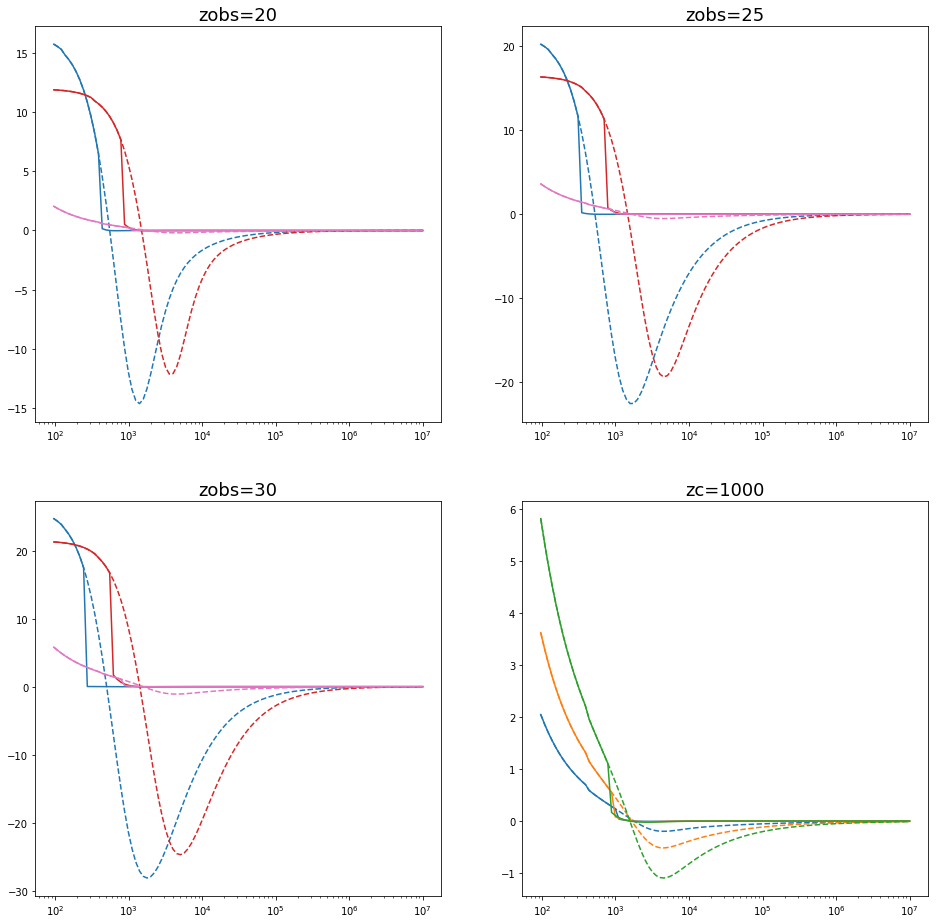

In [8]:
fig, ax = plt.subplots(2, 2,figsize=(16, 16))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0,7,3):
    ax[0,0].semilogx(klist,TBav[:,i,0]-cn.tcmb0*(1+zlist[0]),label=zclist[i],color=cycle[i])
    ax[0,0].semilogx(klist,TBavnb[:,i,0]-cn.tcmb0*(1+zlist[0]),label=zclist[i],linestyle='--',color=cycle[i])
ax[0,0].set_title(label='zobs=20',size=18)
for i in range(0,7,3):
    ax[0,1].semilogx(klist,TBav[:,i,1]-cn.tcmb0*(1+zlist[1]),label=zclist[i],color=cycle[i])
    ax[0,1].semilogx(klist,TBavnb[:,i,1]-cn.tcmb0*(1+zlist[1]),label=zclist[i],linestyle='--',color=cycle[i])
ax[0,1].set_title(label='zobs=25',size=18)
for i in range(0,7,3):
    ax[1,0].semilogx(klist,TBav[:,i,2]-cn.tcmb0*(1+zlist[2]),label=zclist[i],color=cycle[i])
    ax[1,0].semilogx(klist,TBavnb[:,i,2]-cn.tcmb0*(1+zlist[2]),label=zclist[i],linestyle='--',color=cycle[i])
ax[1,0].set_title(label='zobs=30',size=18)
for i in range(3):
    ax[1,1].semilogx(klist,TBav[:,6,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[1,1].semilogx(klist,TBavnb[:,6,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[1,1].set_title(label='zc=1000',size=18)

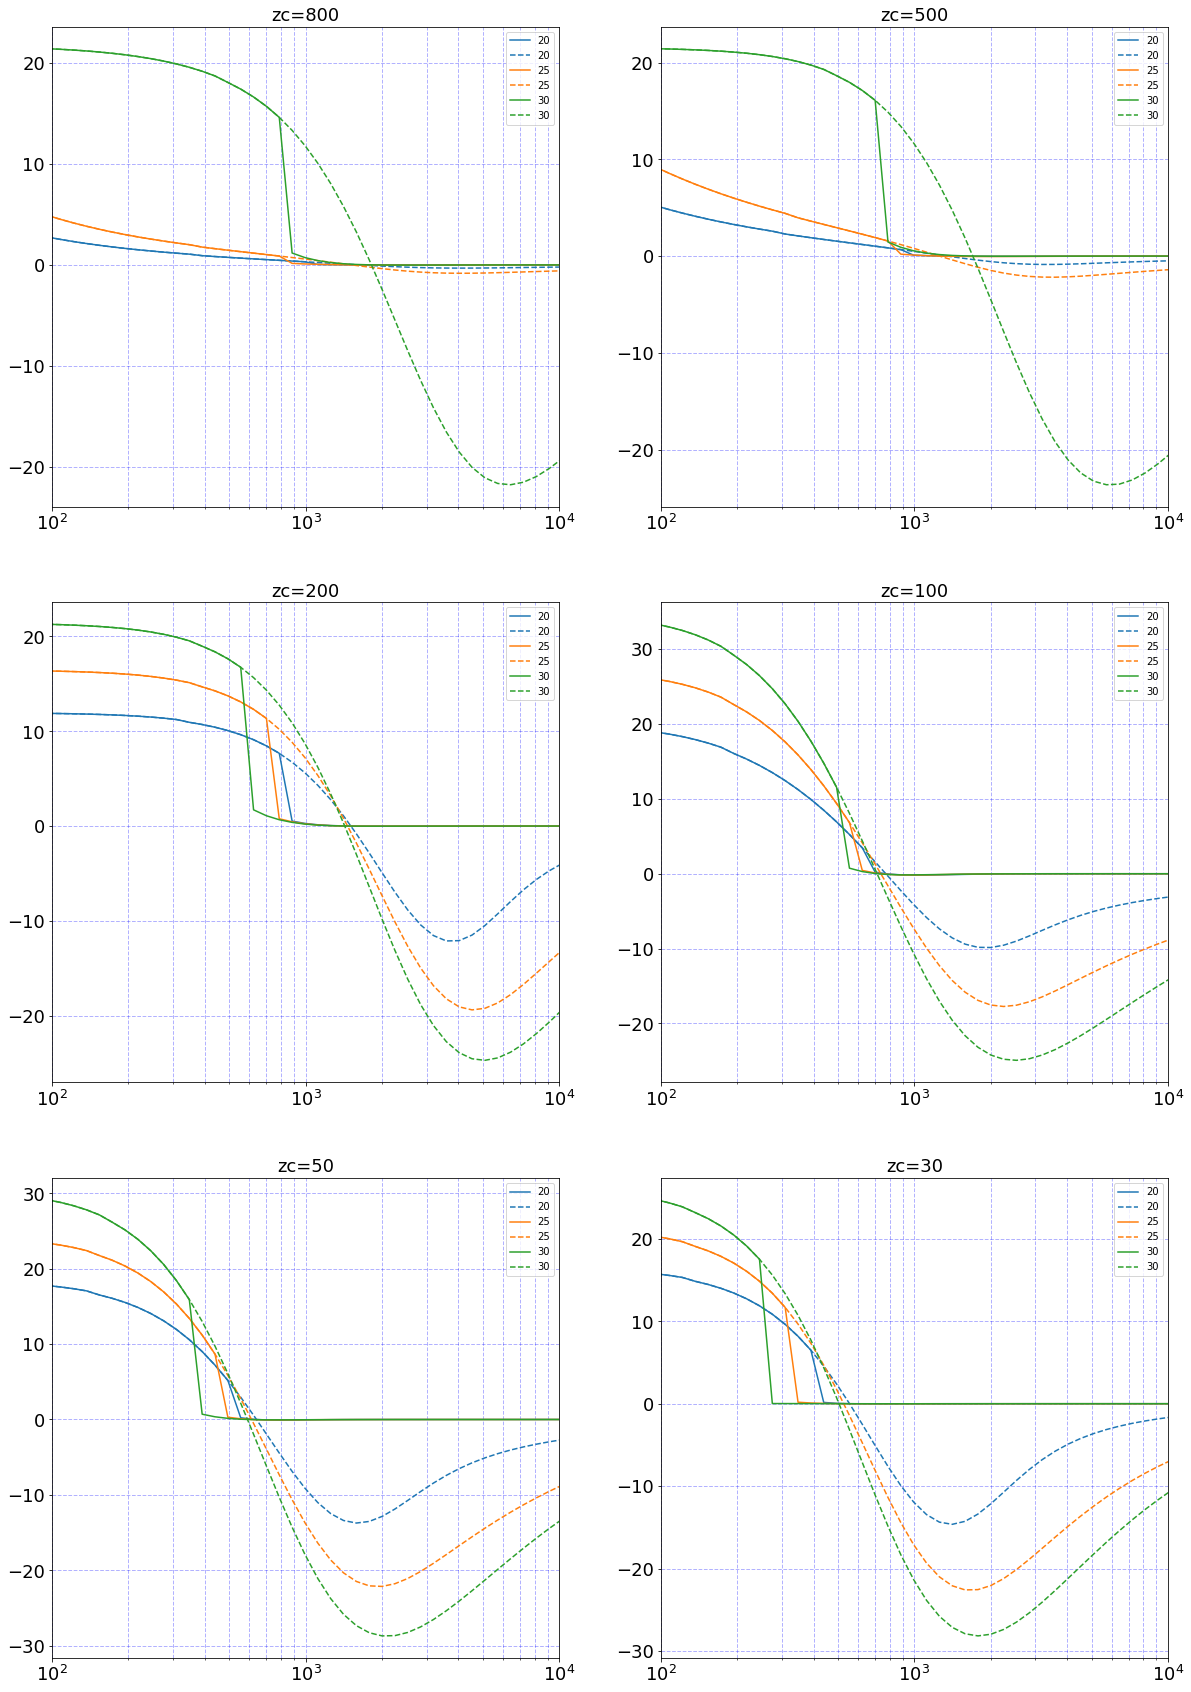

In [9]:
fig, ax = plt.subplots(3, 2,figsize=(20, 30))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(3):
    ax[0,0].semilogx(klist,TBav[:,5,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[0,0].semilogx(klist,TBavnb[:,5,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[0,0].set_title(label='zc=800',size=18)
for i in range(3):
    ax[0,1].semilogx(klist,TBav[:,4,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[0,1].semilogx(klist,TBavnb[:,4,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[0,1].set_title(label='zc=500',size=18)
for i in range(3):
    ax[1,0].semilogx(klist,TBav[:,3,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[1,0].semilogx(klist,TBavnb[:,3,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[1,0].set_title(label='zc=200',size=18)
for i in range(3):
    ax[1,1].semilogx(klist,TBav[:,2,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[1,1].semilogx(klist,TBavnb[:,2,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[1,1].set_title(label='zc=100',size=18)
for i in range(3):
    ax[2,0].semilogx(klist,TBav[:,1,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[2,0].semilogx(klist,TBavnb[:,1,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[2,0].set_title(label='zc=50',size=18)
for i in range(3):
    ax[2,1].semilogx(klist,TBav[:,0,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],color=cycle[i])
    ax[2,1].semilogx(klist,TBavnb[:,0,i]-cn.tcmb0*(1+zlist[i]),label=zlist[i],linestyle='--',color=cycle[i])
ax[2,1].set_title(label='zc=30',size=18)

for i in range(3):
    for j in range(2):
        ax[i,j].grid(which = "both", axis = "both", color = "blue", alpha = 0.3,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        ax[i,j].set_xlim(1e2,1e4)
        ax[i,j].tick_params(labelsize=18)

<font size=10> optical depth $ \tau_{\nu}(z,zc)$ </font>

In [10]:
print(Tauav.shape,taucum.shape)

(100, 8, 3) (100, 8, 3, 101, 101)


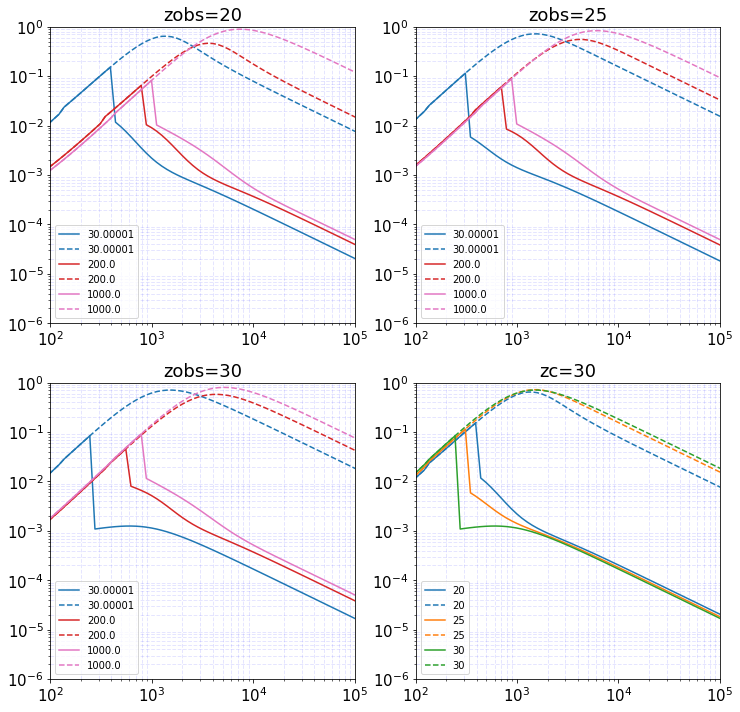

In [11]:
fig, ax = plt.subplots(2, 2,figsize=(12, 12))
for i in range(0,7,3):
    ax[0,0].loglog(klist,Tauav[:,i,0],label=zclist[i],color=cycle[i])
    ax[0,0].loglog(klist,Tauavnb[:,i,0],label=zclist[i],linestyle='--',color=cycle[i])
ax[0,0].set_title(label='zobs=20',size=18)
for i in range(0,7,3):
    ax[0,1].loglog(klist,Tauav[:,i,1],label=zclist[i],color=cycle[i])
    ax[0,1].loglog(klist,Tauavnb[:,i,1],label=zclist[i],linestyle='--',color=cycle[i])
ax[0,1].set_title(label='zobs=25',size=18)
for i in range(0,7,3):
    ax[1,0].loglog(klist,Tauav[:,i,2],label=zclist[i],color=cycle[i])
    ax[1,0].loglog(klist,Tauavnb[:,i,2],label=zclist[i],linestyle='--',color=cycle[i])
ax[1,0].set_title(label='zobs=30',size=18)
for i in range(3):
    ax[1,1].loglog(klist,Tauav[:,0,i],label=zlist[i],color=cycle[i])
    ax[1,1].loglog(klist,Tauavnb[:,0,i],label=zlist[i],linestyle='--',color=cycle[i])
ax[1,1].set_title(label='zc=30',size=18)
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "minor", axis = "both", color = "blue", alpha = 0.1,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        ax[i,j].set_xlim(1e2,1e5)
        ax[i,j].set_ylim(1e-6,1e0)
        ax[i,j].tick_params(labelsize=15)

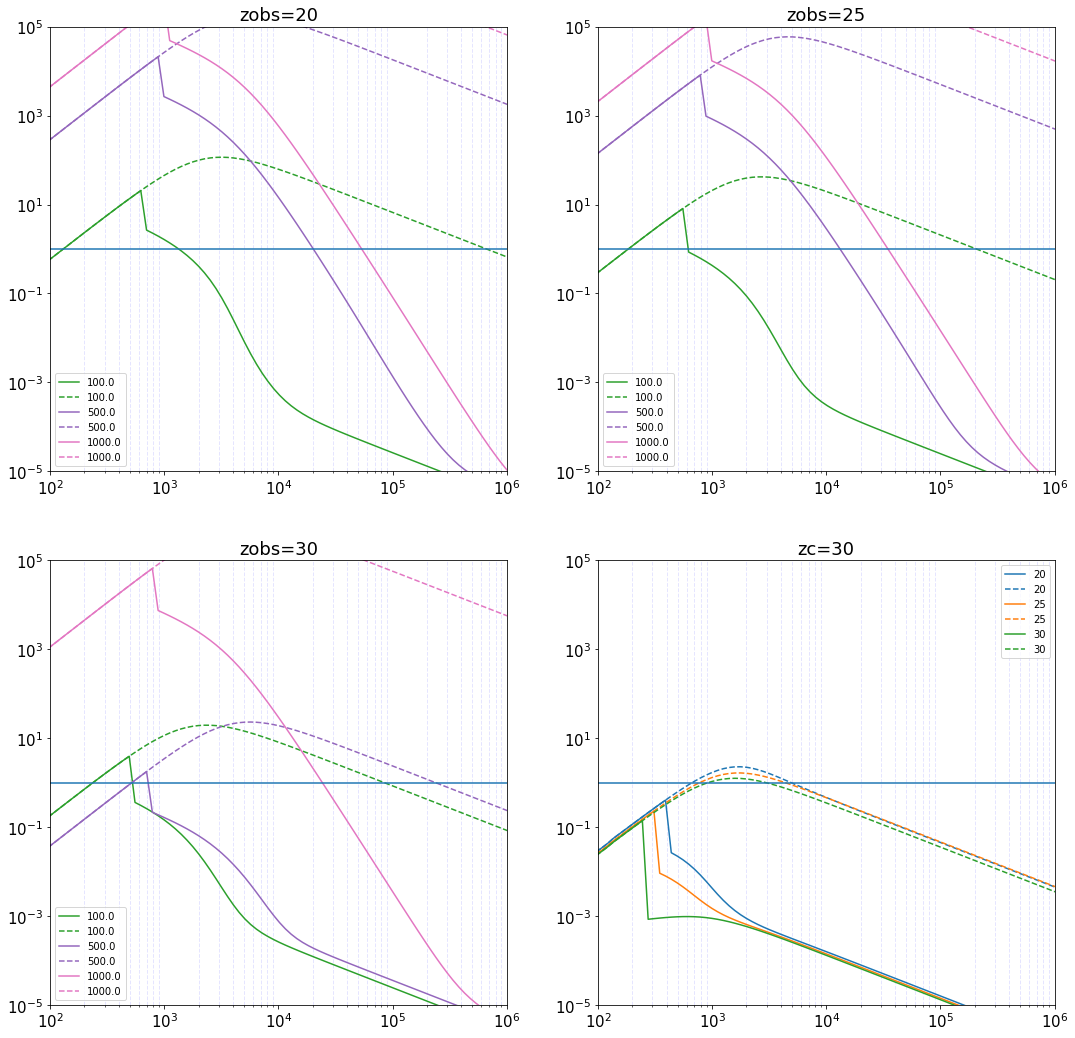

In [12]:
fig, ax = plt.subplots(2, 2,figsize=(18, 18))
for i in range(2,7,2):
    ax[0,0].loglog(klist,taucum[:,i,0,50,50],label=zclist[i],color=cycle[i])
    ax[0,0].loglog(klist,taucumnb[:,i,0,50,50],label=zclist[i],linestyle='--',color=cycle[i])
ax[0,0].set_title(label='zobs=20',size=18)
for i in range(2,7,2):
    ax[0,1].loglog(klist,taucum[:,i,1,50,50],label=zclist[i],color=cycle[i])
    ax[0,1].loglog(klist,taucumnb[:,i,1,50,50],label=zclist[i],linestyle='--',color=cycle[i])
ax[0,1].set_title(label='zobs=25',size=18)
for i in range(2,7,2):
    ax[1,0].loglog(klist,taucum[:,i,2,50,50],label=zclist[i],color=cycle[i])
    ax[1,0].loglog(klist,taucumnb[:,i,2,50,50],label=zclist[i],linestyle='--',color=cycle[i])
ax[1,0].set_title(label='zobs=30',size=18)
for i in range(3):
    ax[1,1].loglog(klist,taucum[:,0,i,50,50],label=zlist[i],color=cycle[i])
    ax[1,1].loglog(klist,taucumnb[:,0,i,50,50],label=zlist[i],linestyle='--',color=cycle[i])
ax[1,1].set_title(label='zc=30',size=18)
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "minor", axis = "both", color = "blue", alpha = 0.1,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        ax[i,j].set_xlim(1e2,1e6)
        ax[i,j].set_ylim(1e-5,1e5)
        ax[i,j].axhline(y=1)
        ax[i,j].tick_params(labelsize=15)

<font size=10>  $T_{\rm{gasave}}(z,zc)$

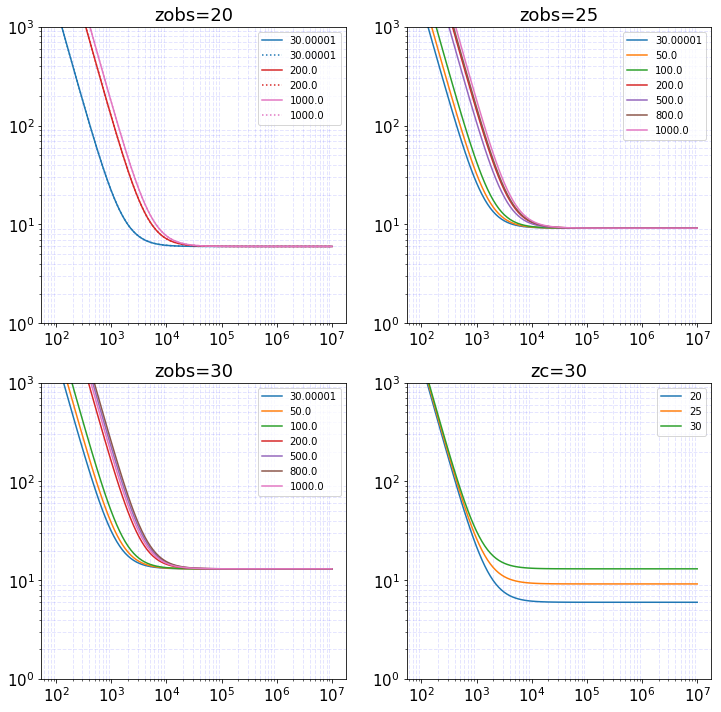

In [13]:
fig, ax = plt.subplots(2, 2,figsize=(12, 12))
for i in range(0,7,3):
    ax[0,0].loglog(klist,TGasave[:,i,0],label=zclist[i],color=cycle[i])
    ax[0,0].loglog(klist,TGasavenb[:,i,0],label=zclist[i],linestyle='dotted',color=cycle[i])
ax[0,0].set_title(label='zobs=20',size=18)
for i in range(7):
    ax[0,1].loglog(klist,TGasave[:,i,1],label=zclist[i])
ax[0,1].set_title(label='zobs=25',size=18)
for i in range(7):
    ax[1,0].loglog(klist,TGasave[:,i,2],label=zclist[i])
ax[1,0].set_title(label='zobs=30',size=18)
for i in range(3):
    ax[1,1].loglog(klist,TGasave[:,0,i],label=zlist[i])
ax[1,1].set_title(label='zc=30',size=18)
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "minor", axis = "both", color = "blue", alpha = 0.1,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        #ax[i,j].set_xlim(1e2,1e4)
        ax[i,j].set_ylim(1,1e3)
        ax[i,j].tick_params(labelsize=15)

<font size=10>  $\rho_{\rm{gasave}}(z,zc)$ </font>

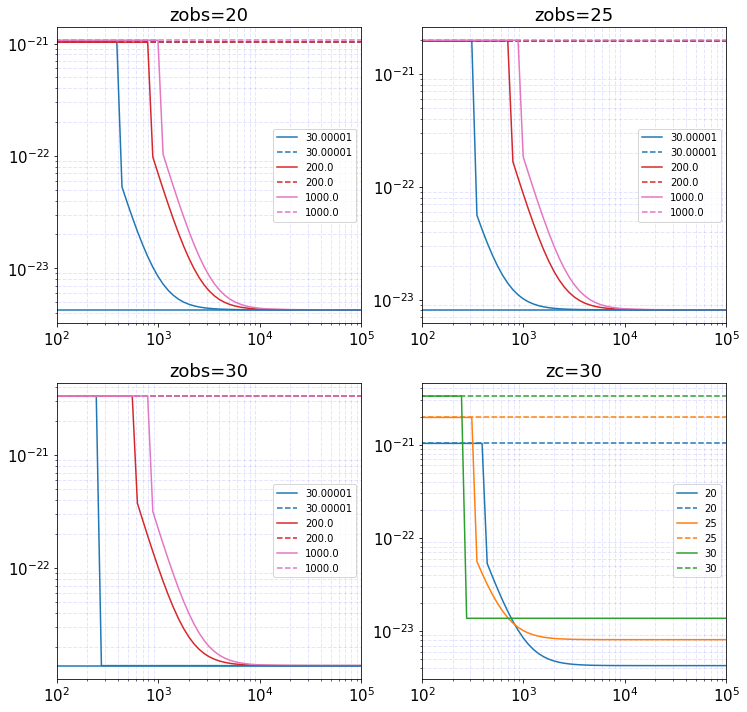

In [14]:
fig, ax = plt.subplots(2, 2,figsize=(12, 12))
for i in range(0,7,3):
    ax[0,0].loglog(klist,RGasave[:,i,0],label=zclist[i],color=cycle[i])
    ax[0,0].loglog(klist,RGasavenb[:,i,0],label=zclist[i],linestyle='--',color=cycle[i])
ax[0,0].set_title(label='zobs=20',size=18)
ax[0,0].axhline(y=ff.rhob(zlist[0]))
for i in range(0,7,3):
    ax[0,1].loglog(klist,RGasave[:,i,1],label=zclist[i],color=cycle[i])
    ax[0,1].loglog(klist,RGasavenb[:,i,1],label=zclist[i],linestyle='--',color=cycle[i])
ax[0,1].set_title(label='zobs=25',size=18)
ax[0,1].axhline(y=ff.rhob(zlist[1]))
for i in range(0,7,3):
    ax[1,0].loglog(klist,RGasave[:,i,2],label=zclist[i],color=cycle[i])
    ax[1,0].loglog(klist,RGasavenb[:,i,2],label=zclist[i],linestyle='--',color=cycle[i])
ax[1,0].set_title(label='zobs=30',size=18)
ax[1,0].axhline(y=ff.rhob(zlist[2]))
for i in range(3):
    ax[1,1].loglog(klist,RGasave[:,0,i],label=zlist[i],color=cycle[i])
    ax[1,1].loglog(klist,RGasavenb[:,0,i],label=zlist[i],linestyle='--',color=cycle[i])
ax[1,1].set_title(label='zc=30',size=18)
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "minor", axis = "both", color = "blue", alpha = 0.1,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        ax[i,j].set_xlim(1e2,1e5)
        #ax[i,j].set_ylim(1e-1,1e3)
        ax[i,j].tick_params(labelsize=15)

<font size=10> $T_{s}(r,z,zc)$ $T_{gas}(r,z,zc)$</font>

In [15]:
@jit ('f8(f8[:],f8[:],f8[:],f8[:],f8[:])')
def TRgaslong(klist,zclist,zlist,k06,k05):
    TS=np.zeros((len(klist),len(zclist),len(zlist),len(k05),len(k05)))
    rgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    tgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    for i,kk in enumerate(klist):
        for j,zc in enumerate(zclist):
            for k,z in enumerate(zlist):
                c,rs,rv,mv=ff.ksUCMHprofiledata(z,zc,kk)
                if (mv>ff.MJ(z)):
                    tg00,rg00,etaM=ff.trg0(z,zc,c,rv,mv,30)
                else:
                    etaM=ff.trg0(z,zc,c,rv,mv,30)[2]
                    tg00,rg00=ff.bondic(kk,z,zc,etaM)
                Tgasigm,Rgasigm=ff.TRgasigm(z)
                Tgas0,Rgas0=ff.TRgas(k06,c,tg00,rg00,etaM)
                Tgas=Tgas0+Tgasigm
                Rgas=Rgas0+Rgasigm
                Tgasave,Rgasave=ff.TRgasave(Tgas,Rgas,k06)
                ts,xc=ff.Ts(k05,k05,z,c,kk,0,tg00,rg00,etaM)
                rgas[i,j,k]=Rgas
                tgas[i,j,k]=Tgas
                TS[i,j,k]=ts
        if(i%50==0):
            print(i)
    return rgas,tgas,Rv,TS

In [16]:
k1=np.logspace(-J,2,dxy)
k2=np.logspace(2,-J,dxy)
k3=np.hstack(([0],k1))
k4=np.hstack((-k2,[0],k1))
Rgas,Tgas,r200,TS=TRgaslong(klist,zclist,zlist,k3,k4)
rdm=cn.Ros(zclist,30)[:,None]/((1+(k3+1e-15))**(1.5)*(k3+1e-15)**(1.5))[None,:]
print(r200.shape)

0
50
(100, 8, 3)


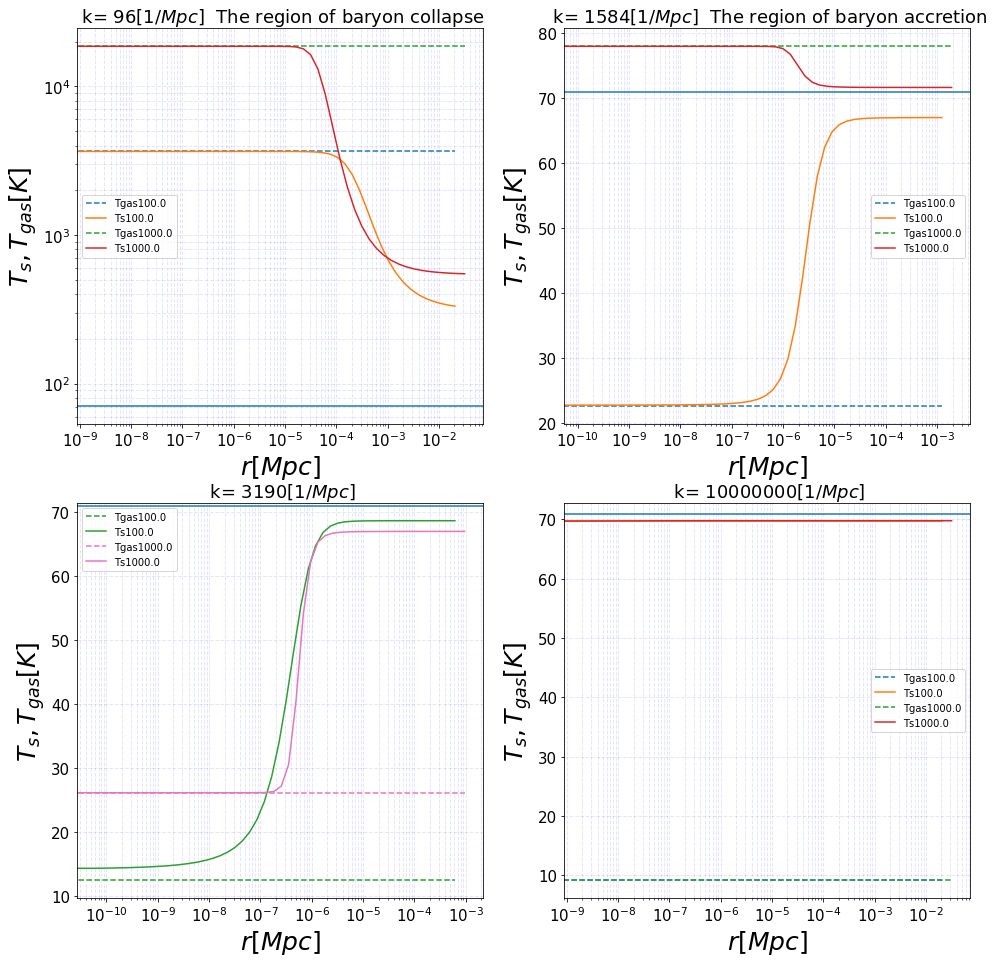

In [17]:
fig, ax = plt.subplots(2, 2,figsize=(16, 16))
for i in range(2,7,4):
    ax[0,0].loglog(k3*r200[0,i,1],Tgas[0,i,1,:],label='Tgas%s'%zclist[i],linestyle='--')
    ax[0,0].loglog(k4*r200[0,i,1],TS[0,i,1,50,:],label='Ts%s'%zclist[i])
ax[0,0].set_title(label=' k= {0:.0f}$[1/Mpc ]$  The region of baryon collapse'.format(klist[0]),size=18)
for i in range(2,7,4):
    ks=24
    ax[0,1].semilogx(k3*r200[ks,i,1],Tgas[ks,i,1,:],label='Tgas%s'%zclist[i],linestyle='--')
    ax[0,1].semilogx(k4*r200[ks,i,1],TS[ks,i,1,50,:],label='Ts%s'%zclist[i])
    #ax[0,1].semilogx(k05,TSnb[27,i,1,50,:],label='Tsnb%s'%zclist[i],color=cycle[i],linestyle='dotted')
ax[0,1].set_title(label=' k= {0:.0f}$[1/Mpc ]$  The region of baryon accretion'.format(klist[ks]),size=18)
for i in range(2,7,4):
    ks=30
    ax[1,0].semilogx(k3*r200[ks,i,1],Tgas[ks,i,1,:],label='Tgas%s'%zclist[i],linestyle='--',color=cycle[i])
    ax[1,0].semilogx(k4*r200[ks,i,1],TS[ks,i,1,50,:],label='Ts%s'%zclist[i],color=cycle[i])
    #ax[1,0].semilogx(k05*r200[40,i,1],TSnb[40,i,1,50,:],label='Tsnb%s'%zclist[i],color=cycle[i],linestyle='dotted')
ax[1,0].set_title(label=' k= {0:.0f}$[1/Mpc ]$'.format(klist[ks]),size=18)
for i in range(2,7,4):
    ax[1,1].semilogx(k3*r200[0,i,1],Tgas[99,i,1,:],label='Tgas%s'%zclist[i],linestyle='--')
    ax[1,1].semilogx(k4*r200[0,i,1],TS[99,i,1,50,:],label='Ts%s'%zclist[i])
ax[1,1].set_title(label=' k= {0:.0f}$[1/Mpc]$'.format(klist[99]),size=18)
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = "both", axis = "both", color = "blue", alpha = 0.1,
        linestyle = "--", linewidth = 1)
        ax[i,j].legend()
        ax[i,j].axhline(y=cn.tcmb0*(1+zlist[1]))
        #ax[i,j].set_xlim(1e2,1e4)
        #ax[i,j].set_ylim(1,1e3)
        ax[i,j].tick_params(labelsize=15)
        ax[i,j].set_xlabel(r'$r[Mpc]$',size=25)
        ax[i,j].set_ylabel(r'$T_{s},T_{gas}[K]$',size=25)

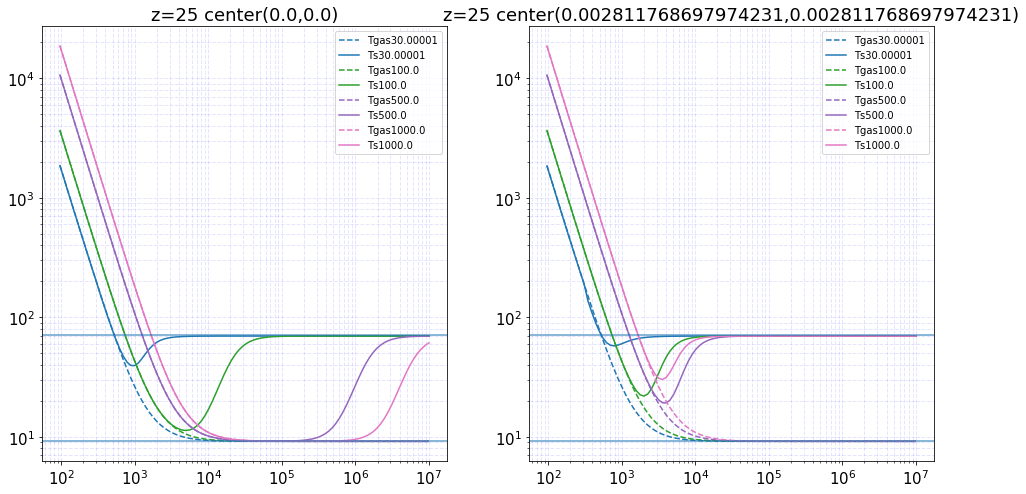

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))
for i in range(0,7,2):
    ax[0].loglog(klist,tgas[:,i,1,0],label='Tgas%s'%zclist[i],linestyle='--',color=cycle[i])
    ax[0].loglog(klist,TS[:,i,1,50,50],label='Ts%s'%zclist[i],color=cycle[i])
ax[0].set_title(label='z={0} center({1},{2})'.format(zlist[1],k05[50],k05[50]),size=18)
for i in range(0,7,2):
    ax[1].loglog(klist,tgas[:,i,1,25],label='Tgas%s'%zclist[i],linestyle='--',color=cycle[i])
    ax[1].loglog(klist,TS[:,i,1,75,75],label='Ts%s'%zclist[i],color=cycle[i])
ax[1].set_title(label='z={0} center({1},{2})'.format(zlist[1],k05[75],k05[75]),size=18)
for j in range(2):
    ax[j].grid(which = "both", axis = "both", color = "blue", alpha = 0.1,
    linestyle = "--", linewidth = 1)
    ax[j].legend()
    ax[j].axhline(y=cn.tcmb0*(1+zlist[1]),alpha=0.7)
    ax[j].axhline(y=ff.TRgasigm(zlist[1])[0],alpha=0.7)
    #ax[j].set_xlim(1e2,1e4)
    #ax[j].set_ylim(1,1e3)
    ax[j].tick_params(labelsize=15)


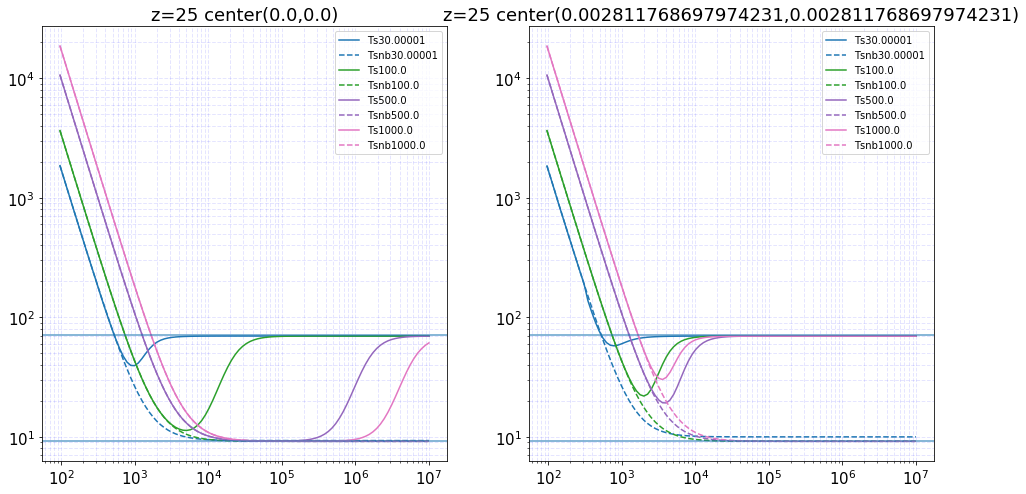

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))
for i in range(0,7,2):
    ax[0].loglog(klist,TS[:,i,1,50,50],label='Ts%s'%zclist[i],color=cycle[i])
    ax[0].loglog(klist,TSnb[:,i,1,50,50],label='Tsnb%s'%zclist[i],linestyle='--',color=cycle[i])
ax[0].set_title(label='z={0} center({1},{2})'.format(zlist[1],k05[50],k05[50]),size=18)
for i in range(0,7,2):
    ax[1].loglog(klist,TS[:,i,1,75,75],label='Ts%s'%zclist[i],color=cycle[i])
    ax[1].loglog(klist,TSnb[:,i,1,75,75],label='Tsnb%s'%zclist[i],linestyle='--',color=cycle[i])
ax[1].set_title(label='z={0} center({1},{2})'.format(zlist[1],k05[75],k05[75]),size=18)
for j in range(2):
    ax[j].grid(which = "both", axis = "both", color = "blue", alpha = 0.1,
    linestyle = "--", linewidth = 1)
    ax[j].legend()
    ax[j].axhline(y=cn.tcmb0*(1+zlist[1]),alpha=0.7)
    ax[j].axhline(y=ff.TRgasigm(zlist[1])[0],alpha=0.7)
    #ax[j].set_xlim(1e2,1e4)
    #ax[j].set_ylim(1,1e3)
    ax[j].tick_params(labelsize=15)

<font size=10> $\rho_{gas}(r,z,zc),\rho_{dm}(r,z,zc)$</font>

In [20]:
@jit ('f8(f8[:],f8[:],f8[:],f8[:])')
def TRgaslong(klist,zclist,zlist,k06):
    rgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    tgas=np.zeros((len(klist),len(zclist),len(zlist),len(k06)))
    Rv=np.zeros((len(klist),len(zclist),len(zlist)))
    for i,kk in enumerate(klist):
        for j,zc in enumerate(zclist):
            for k,z in enumerate(zlist):
                c,rs,rv,mv=ff.ksUCMHprofiledata(z,zc,kk)
                if (mv>ff.MJ(z)):
                    tg00,rg00,etaM=ff.trg0(z,zc,c,rv,mv,30)
                else:
                    etaM=ff.trg0(z,zc,c,rv,mv,30)[2]
                    tg00,rg00=ff.bondic(kk,z,zc,etaM)
                Tgasigm,Rgasigm=ff.TRgasigm(z)
                Tgas0,Rgas0=ff.TRgas(k06,c,tg00,rg00,etaM)
                Tgas=Tgas0+Tgasigm
                Rgas=Rgas0+Rgasigm
                rgas[i,j,k]=Rgas
                tgas[i,j,k]=Tgas
                Rv[i,j,k]=rv
        if(i%50==0):
            print(i)
    return rgas,tgas,Rv

In [21]:
k1=np.logspace(-J,2,dxy)
k2=np.hstack(([0],k1))
Rgas,Tgas,r200=TRgaslong(klist,zclist,zlist,k2)
rdm=cn.Ros(zclist,30)[:,None]/((1+(k2+1e-15))**(1.5)*(k2+1e-15)**(1.5))[None,:]
print(r200.shape)

0
50
(100, 8, 3)


In [22]:
#print(Rgas)

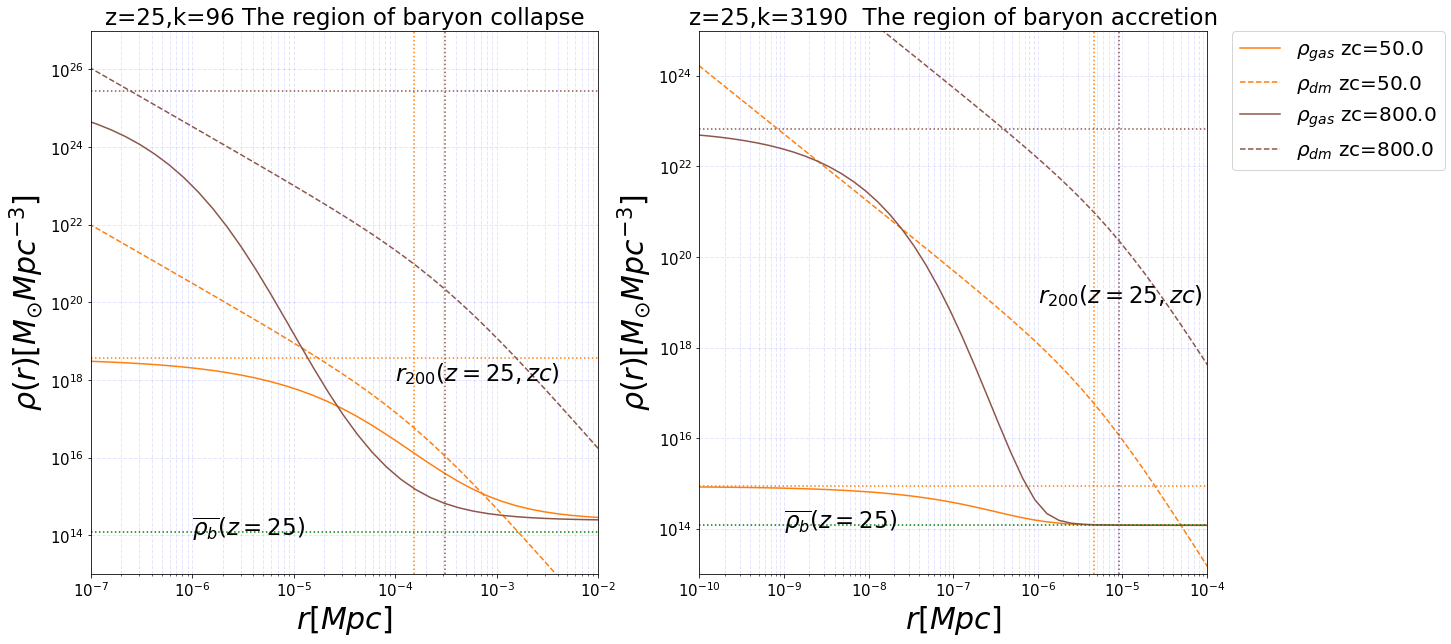

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
for i in range(1,7,4):
    ax[0].loglog(k2*r200[0,i,1],Rgas[0,i,1,:]*cn.kgm_MMpc,label=r'$\rho_{gas}$ zc=%s'%zclist[i],color=cycle[i])
    ax[0].loglog(k2*r200[0,i,1],rdm[i,:]*cn.kgm_MMpc,label=r'$\rho_{dm}$ zc=%s'%zclist[i],color=cycle[i],linestyle='--')
    ax[0].axvline(x=r200[0,i,1],color=cycle[i],linestyle='dotted')
    ax[0].axhline(y=Rg0[0,i,1]*cn.kgm_MMpc,color=cycle[i],linestyle='dotted')
ax[0].text(1e-6,1e14,r'$\overline{\rho_{b}}(z=25)$',size=23)
ax[0].text(1e-4,1e18,r'$r_{200}(z=25,zc)$',size=23)
ax[0].set_ylim(1e13,1e27)
ax[0].set_xlim(1e-7,1e-2)
ax[0].set_title(label='z={0},k={1:.0f} The region of baryon collapse'.format(zlist[1],klist[0]),size=23)
for i in range(1,7,4):
    ax[1].loglog(k2*r200[30,i,1],Rgas[30,i,1,:]*cn.kgm_MMpc,label=r'$\rho_{gas}$ zc=%s'%zclist[i],color=cycle[i])
    ax[1].loglog(k2*r200[30,i,1],rdm[i,:]*cn.kgm_MMpc,label=r'$\rho_{dm}$ zc=%s'%zclist[i],color=cycle[i],linestyle='--')
    ax[1].axvline(x=r200[30,i,1],color=cycle[i],linestyle='dotted')
    ax[1].axhline(y=Rg0[30,i,1]*cn.kgm_MMpc,color=cycle[i],linestyle='dotted')
ax[1].set_title(label='z={0},k={1:.0f}  The region of baryon accretion'.format(zlist[1],klist[30]),size=23)
ax[1].set_ylim(1e13,1e25)
ax[1].set_xlim(1e-10,1e-4)
ax[1].text(1e-9,1e14,r'$\overline{\rho_{b}}(z=25)$',size=23)
ax[1].text(1e-6,1e19,r'$r_{200}(z=25,zc)$',size=23)
for j in range(2):
    ax[j].grid(which = "both", axis = "both", color = "blue", alpha = 0.1,
    linestyle = "--", linewidth = 1)
    ax[j].axhline(y=ff.rhob(zlist[1])*cn.kgm_MMpc,linestyle='dotted',color='green')
    ax[j].tick_params(labelsize=15)
    ax[j].set_xlabel(r'$r[Mpc]$',size=30)
    ax[j].set_ylabel(r'$\rho(r)[M_{\odot} Mpc^{-3}]$',size=30)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20)

バリオン質量の確認（外側で下がってたら内側で上がっているはず！！